In [12]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score
import json
import matplotlib.pyplot as plt

In [ ]:
# load data
train = pd.read_csv('../data/train.csv')
print(f"Training data: {train.shape}")

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Training data: (159571, 8)
Test data: (63978, 8)


In [3]:
# 4-fold cross validation stratefied on 'Toxic'
skf = StratifiedKFold(n_splits=4, shuffle=True)
folds = list(skf.split(train, train['toxic']))

print(f"4-Fold CV Split:")
for fold_idx, (train_idx, val_idx) in enumerate(folds):
    print(f"Fold {fold_idx+1}: Train={len(train_idx):,} | Val={len(val_idx):,}")

4-Fold CV Split:
Fold 1: Train=119,678 | Val=39,893
Fold 2: Train=119,678 | Val=39,893
Fold 3: Train=119,678 | Val=39,893
Fold 4: Train=119,679 | Val=39,892


In [23]:
# hyperparameters
max_features_values = [10000, 20000, 30000]
c_values = [0.1, 1.0, 10]

In [24]:
# grid search with 4-fold cross-validation
results = []

print("Running grid search (3 max_features x 3 C_values = 9 combinations)...\n")

for max_features in max_features_values:
    # vectorizer n max_features
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=(1,2))
    X_all = vectorizer.fit_transform(train['comment_text'])
    
    for c in c_values:
        print(f"For max_features={max_features}, C={c}...")
        
        # fold-level metrics
        fold_precisions = []
        fold_recalls = []
        fold_f1s = []
        fold_auc_prs = []
        per_label_auc_prs = {label: [] for label in labels}
        
        # 4-fold cv
        for fold_idx, (train_idx, val_idx) in enumerate(folds):
            print(f"Starting fold {fold_idx+1}...", end=' ')

            X_train_fold = X_all[train_idx]
            X_val_fold = X_all[val_idx]
            
            # label-level metrics
            label_f1s = []
            label_precisions = []
            label_recalls = []
            label_auc_prs = []
            
            # train one model per label
            for label in labels:
                y_train_fold = train[label].iloc[train_idx]
                y_val_fold = train[label].iloc[val_idx]
                
                # train SVM
                model = LinearSVC(
                    C=c, 
                    penalty='l2', 
                    class_weight='balanced', 
                    max_iter=5000
                )
                model.fit(X_train_fold, y_train_fold)
                
                # predict
                y_pred = model.predict(X_val_fold)
                y_scores = model.decision_function(X_val_fold)  # for AUC-PR
                
                # calculate metrics
                f1 = f1_score(y_val_fold, y_pred, zero_division=0)
                precision = precision_score(y_val_fold, y_pred, zero_division=0)
                recall = recall_score(y_val_fold, y_pred, zero_division=0)
                auc_pr = average_precision_score(y_val_fold, y_scores)
                
                label_f1s.append(f1)
                label_precisions.append(precision)
                label_recalls.append(recall)
                label_auc_prs.append(auc_pr)
                per_label_auc_prs[label].append(auc_pr)
            
            # macro average across labels for this fold
            fold_f1s.append(np.mean(label_f1s))
            fold_precisions.append(np.mean(label_precisions))
            fold_recalls.append(np.mean(label_recalls))
            fold_auc_prs.append(np.mean(label_auc_prs))

            print(f"Done!")
        
        # average across folds
        result = {
            "max_features": max_features,
            "C": c,
            "macro_precision": round(np.mean(fold_precisions), 3),
            "macro_recall": round(np.mean(fold_recalls), 3),
            "macro_f1": round(np.mean(fold_f1s), 3),
            "macro_auc_pr": round(np.mean(fold_auc_prs), 3),
            "per_label_auc_pr": {label: round(np.mean(per_label_auc_prs[label]), 3) for label in labels}
        }
        results.append(result)
        print(f"Macro_f1={result['macro_f1']}\n")

# save results to json
with open('../results/linear_svm_tuning_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nResults saved to ../results/linear_svm_tuning_results.json")

Running grid search (3 max_features x 3 C_values = 9 combinations)...

For max_features=10000, C=0.1...
Starting fold 1... Done!
Starting fold 2... Done!
Starting fold 3... Done!
Starting fold 4... Done!
Macro_f1=0.518

For max_features=10000, C=1.0...
Starting fold 1... Done!
Starting fold 2... Done!
Starting fold 3... Done!
Starting fold 4... Done!
Macro_f1=0.527

For max_features=10000, C=10...
Starting fold 1... Done!
Starting fold 2... Done!
Starting fold 3... Done!
Starting fold 4... Done!
Macro_f1=0.488

For max_features=20000, C=0.1...
Starting fold 1... Done!
Starting fold 2... Done!
Starting fold 3... Done!
Starting fold 4... Done!
Macro_f1=0.554

For max_features=20000, C=1.0...
Starting fold 1... Done!
Starting fold 2... Done!
Starting fold 3... Done!
Starting fold 4... Done!
Macro_f1=0.568

For max_features=20000, C=10...
Starting fold 1... Done!
Starting fold 2... Done!
Starting fold 3... Done!
Starting fold 4... Done!
Macro_f1=0.514

For max_features=30000, C=0.1...
Star

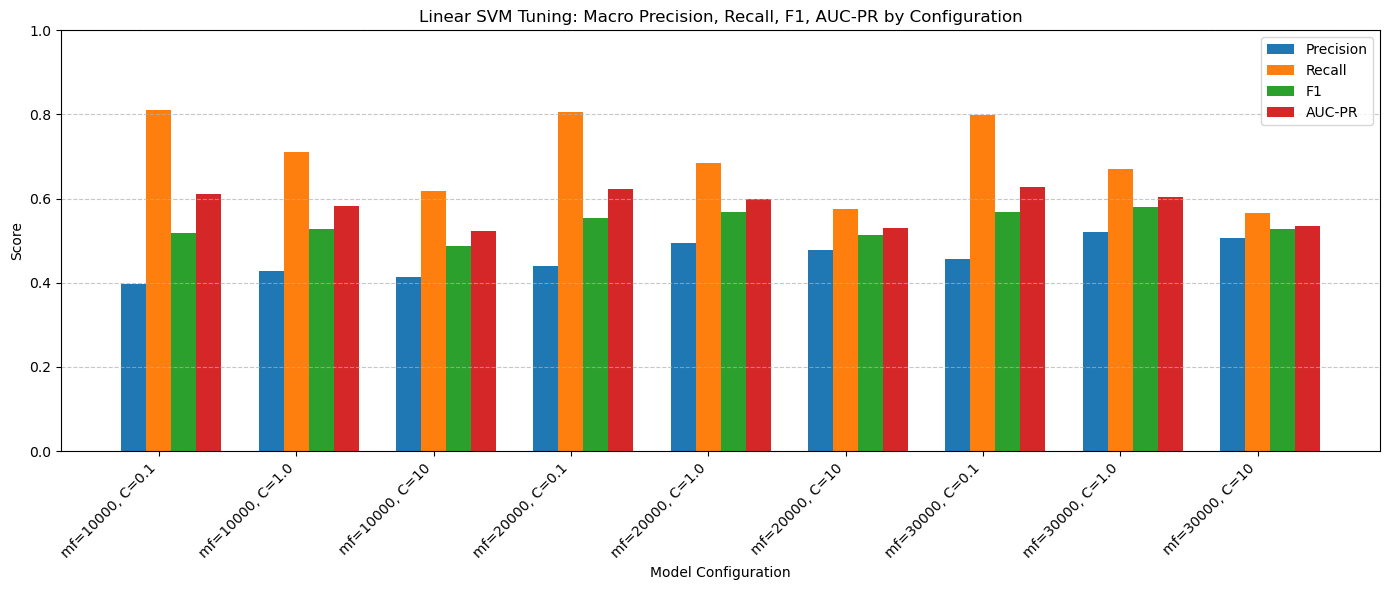


Best model: mf=30000, C=1.0
  Macro Precision: 0.521
  Macro Recall: 0.67
  Macro F1: 0.581
  Macro AUC-PR: 0.604

Best result saved to ../results/linear_svm_tuning_best.json


In [25]:
# load results
with open('../results/linear_svm_tuning_results.json', 'r') as f:
    results = json.load(f)

# create labels for each model config
model_labels = [f"mf={r['max_features']}, C={r['C']}" for r in results]
precisions = [r['macro_precision'] for r in results]
recalls = [r['macro_recall'] for r in results]
f1s = [r['macro_f1'] for r in results]
auc_prs = [r['macro_auc_pr'] for r in results]

# bar chart
x = np.arange(len(model_labels)) * 1.1  # add spacing between groups
width = 0.2

fig, ax = plt.subplots(figsize=(14, 6))

bars1 = ax.bar(x - width, precisions, width, label='Precision')
bars2 = ax.bar(x, recalls, width, label='Recall')
bars3 = ax.bar(x + width, f1s, width, label='F1')
bars4 = ax.bar(x + width*2, auc_prs, width, label='AUC-PR')

ax.set_xlabel('Model Configuration')
ax.set_ylabel('Score')
ax.set_title('Linear SVM Tuning: Macro Precision, Recall, F1, AUC-PR by Configuration')
ax.set_xticks(x)
ax.set_xticklabels(model_labels, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# find best model by macro_f1
best_idx = np.argmax(f1s)
best_result = results[best_idx]

print(f"\nBest model: {model_labels[best_idx]}")
print(f"  Macro Precision: {best_result['macro_precision']}")
print(f"  Macro Recall: {best_result['macro_recall']}")
print(f"  Macro F1: {best_result['macro_f1']}")
print(f"  Macro AUC-PR: {best_result['macro_auc_pr']}")

# save best result in same format as bert_tuning_best.json
best_output = {
    "max_features": best_result['max_features'],
    "C": best_result['C'],
    "macro_precision": best_result['macro_precision'],
    "macro_recall": best_result['macro_recall'],
    "macro_f1": best_result['macro_f1'],
    "macro_auc_pr": best_result['macro_auc_pr'],
    "per_label_auc_pr": best_result['per_label_auc_pr']
}

with open('../results/linear_svm_tuning_best.json', 'w') as f:
    json.dump(best_output, f, indent=2)

print(f"\nBest result saved to ../results/linear_svm_tuning_best.json")